# Comparisons of all-season thickness data with BGEP ULS sea ice draft estimates

**Summary:** In this notebook, we produce comparisons of all-season monthly gridded ICESat-2 and CryoSat-2 sea ice thickness data with draft measurements obtained from Upward Looking Sonar moorings deployed in the Beaufort Sea. 

 
**Version history**: Version 1 (05/01/2025)
 

# Import notebook dependencies

In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
import itertools
import pyproj 
from netCDF4 import Dataset
import scipy.interpolate 
from utils.read_data_utils import read_book_data, read_IS2SITMOGR4 # Helper function for reading the data from the bucket
from utils.plotting_utils import compute_gridcell_winter_means, interactiveArcticMaps, interactive_winter_mean_maps, interactive_winter_comparison_lineplot # Plotting
from extra_funcs import apply_interpolation_time
from scipy import stats
import datetime
# Plotting dependencies
import cartopy.crs as ccrs
from textwrap import wrap
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 00 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

In [2]:
# Set some plotting parameters
mpl.rcParams.update({
    "text.usetex": False,  # Use LaTeX for rendering
    "font.family": "sans-serif",
    "lines.linewidth": 1.,
    "font.size": 8,
    #"lines.alpha": 0.8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8
})
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['figure.dpi'] = 300 

In [3]:
# DO ONE RUN APR 2021 WITH SM AS THIS IS WHEN IT IS AVAILABLE TO
start_date = "Nov 2018"
end_date = "July 2021"
options = {
    'IS-2/SM-LG': {'thickness': 'ice_thickness_sm_int', 'snow_depth': 'snow_depth_sm_int'},
    'CS-2/SM-LG': {'thickness': 'ice_thickness_cs2_ubris', 'snow_depth': 'snow_depth_sm_int'}
}


In [4]:
# Load the all-season wrangled dataset
IS2_CS2_allseason = xr.open_dataset('./data/book_data_allseason.nc')
print("Successfully loaded all-season wrangled dataset")

Successfully loaded all-season wrangled dataset


In [5]:

# Get some map proj info needed for later functions
out_proj = 'EPSG:3411'
mapProj = pyproj.Proj("+init=" + out_proj)

xIS2 = IS2_CS2_allseason.x.values
yIS2 = IS2_CS2_allseason.y.values
xptsIS2, yptsIS2 = np.meshgrid(xIS2, yIS2)

out_lons = IS2_CS2_allseason.longitude.values
out_lats = IS2_CS2_allseason.latitude.values


In [6]:
int_str = '_int'

In [7]:
# Estimate ice draft from the ICESat-2 data for more direct comparison with ULS draft measurements
# NB: Another option (not taken) is to simply multiply ULS drafts by 1.1 to convert to thickness (AWI do this)
# Include extra var = '_int' to use interpolated values, not recommended for validation purposes. 
# Define the variables for each option

IS2_CS2_allseason[f'ice_draft_IS-2/SM-LG'] = (IS2_CS2_allseason['ice_thickness_sm'+int_str] - IS2_CS2_allseason['freeboard'+int_str] + IS2_CS2_allseason['snow_depth_sm'+int_str])

IS2_CS2_allseason[f'ice_draft_CS-2/SM-LG'] = ((IS2_CS2_allseason['ice_thickness_cs2_ubris']*IS2_CS2_allseason['cs2_sea_ice_density_UBRIS']) + (IS2_CS2_allseason['snow_depth_sm'+int_str] + IS2_CS2_allseason['snow_density_sm'+int_str]))/1024.



In [8]:
# Initialize map projection and project data to it

IS2_date_range = pd.date_range(start=start_date, end=end_date, freq='MS')+ pd.Timedelta(days=14)# MS indicates a time frequency of start of the month
#IS2_date_range = IS2_date_range[((IS2_date_range.month <5) | (IS2_date_range.month > 8))]
IS2_date_range_strs=[str(date.year)+'-%02d'%(date.month) for date in IS2_date_range]
IS2_date_range_strs

['2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06',
 '2020-07',
 '2020-08',
 '2020-09',
 '2020-10',
 '2020-11',
 '2020-12',
 '2021-01',
 '2021-02',
 '2021-03',
 '2021-04',
 '2021-05',
 '2021-06',
 '2021-07']

In [9]:
# This is the value in meters of the aggregation length-scale for the IS-2/CS-2 data. 
# A compromise between the 50km used in the original BGEP analysis and the 150km used in the Landy2022 analysis.
comp_res=100000

In [10]:
# Wrange ULS data
# Could really convert this to another data wrangling notebook and store the derived output as netcdfs

dataPathULS='./data/'

def get_ULS_dates(uls_mean_monthly_draft, uls_dates, date):
    #print(date)
    try:
        return uls_mean_monthly_draft[uls_dates==date].values[0]
    except:
        return np.nan

def get_uls_year(letter, year):
    if letter=='a':
        print('Mooring A (75.0 N, 150 W)')
        uls_x, uls_y = mapProj(-150., 75.)
    if letter=='b':
        print('Mooring B (78.4 N, 150.0 W)')
        uls_x, uls_y = mapProj(-150., 78.4)
    if letter=='d':
        print('Mooring D (74.0 N, 140.0 W)')
        uls_x, uls_y = mapProj(-140., 74.)
 
    uls = pd.read_csv(dataPathULS+'uls'+year+letter+'_draft.dat', sep='\s+',names = ['date', 'time', 'draft'], header=2)
    print(uls.head(10))
    utc_datetime_uls = pd.to_datetime(uls['date'], format='%Y%m%d')
    uls_mean_daily_draft = uls['draft'].groupby([utc_datetime_uls.dt.date]).mean() 

    uls_mean_monthly_draft = uls['draft'].groupby([utc_datetime_uls.dt.to_period('m')]).mean() 
    #print(uls_mean_monthly_draft)
    
    return uls_mean_daily_draft, uls_mean_monthly_draft, uls_x, uls_y




In [11]:
uls_mean_daily_draft_a_18, uls_mean_monthly_draft_a_18, uls_x_a, uls_y_a = get_uls_year('a', '18')
uls_mean_daily_draft_b_18, uls_mean_monthly_draft_b_18, uls_x_b, uls_y_b = get_uls_year('b', '18')
uls_mean_daily_draft_d_18, uls_mean_monthly_draft_d_18, uls_x_d, uls_y_d = get_uls_year('d', '18')

Mooring A (75.0 N, 150 W)
       date    time  draft
0  20180925  234211    0.0
1  20180925  234212    0.0
2  20180925  234213    0.0
3  20180925  234214    0.0
4  20180925  234215    0.0
5  20180925  234216    0.0
6  20180925  234217    0.0
7  20180925  234218    0.0
8  20180925  234219    0.0
9  20180925  234220    0.0
Mooring B (78.4 N, 150.0 W)
       date   time  draft
0  20180923  20901    0.0
1  20180923  20902    0.0
2  20180923  20903    0.0
3  20180923  20904    0.0
4  20180923  20905    0.0
5  20180923  20906    0.0
6  20180923  20907    0.0
7  20180923  20908    0.0
8  20180923  20909    0.0
9  20180923  20910    0.0
Mooring D (74.0 N, 140.0 W)
       date   time  draft
0  20180915  10011    0.0
1  20180915  10012    0.0
2  20180915  10013    0.0
3  20180915  10014    0.0
4  20180915  10015    0.0
5  20180915  10016    0.0
6  20180915  10017    0.0
7  20180915  10018    0.0
8  20180915  10019    0.0
9  20180915  10020    0.0


In [12]:
uls_mean_daily_draft_a_21, uls_mean_monthly_draft_a_21, _, _ = get_uls_year('a', '21')
uls_mean_daily_draft_b_21, uls_mean_monthly_draft_b_21, _, _ = get_uls_year('b', '21')
uls_mean_daily_draft_d_21, uls_mean_monthly_draft_d_21, _, _ = get_uls_year('d', '21')   

Mooring A (75.0 N, 150 W)
       date    time  draft
0  20210828  235411   2.11
1  20210828  235412   2.04
2  20210828  235413   1.96
3  20210828  235414   1.89
4  20210828  235415   1.82
5  20210828  235416   1.75
6  20210828  235417   1.68
7  20210828  235418   1.61
8  20210828  235419   1.54
9  20210828  235420   1.48
Mooring B (78.4 N, 150.0 W)
       date    time  draft
0  20210831  222825    0.0
1  20210831  222826    0.0
2  20210831  222827    0.0
3  20210831  222828    0.0
4  20210831  222829    0.0
5  20210831  222830    0.0
6  20210831  222831    0.0
7  20210831  222832    0.0
8  20210831  222833    0.0
9  20210831  222834    0.0
Mooring D (74.0 N, 140.0 W)
       date  time  draft
0  20210909  4745    0.0
1  20210909  4746    0.0
2  20210909  4747    0.0
3  20210909  4748    0.0
4  20210909  4749    0.0
5  20210909  4750    0.0
6  20210909  4751    0.0
7  20210909  4752    0.0
8  20210909  4753    0.0
9  20210909  4754    0.0


In [13]:
# Combine data for all years
uls_mean_daily_draft_a = pd.concat([uls_mean_daily_draft_a_18, uls_mean_daily_draft_a_21])
uls_mean_daily_draft_b = pd.concat([uls_mean_daily_draft_b_18, uls_mean_daily_draft_b_21])
uls_mean_daily_draft_d = pd.concat([uls_mean_daily_draft_d_18, uls_mean_daily_draft_d_21])

# Combine data for all years
uls_mean_monthly_draft_a = pd.concat([uls_mean_monthly_draft_a_18, uls_mean_monthly_draft_a_21])
uls_mean_monthly_draft_b = pd.concat([uls_mean_monthly_draft_b_18, uls_mean_monthly_draft_b_21])
uls_mean_monthly_draft_d = pd.concat([uls_mean_monthly_draft_d_18, uls_mean_monthly_draft_d_21])

In [14]:
end_date = "2021-08-01"
uls_mean_daily_draft_a = uls_mean_daily_draft_a[uls_mean_daily_draft_a.index < np.datetime64(end_date)].dropna()
uls_mean_daily_draft_b = uls_mean_daily_draft_b[uls_mean_daily_draft_b.index < np.datetime64(end_date)].dropna()
uls_mean_daily_draft_d = uls_mean_daily_draft_d[uls_mean_daily_draft_d.index < np.datetime64(end_date)].dropna()

uls_mean_monthly_draft_a = uls_mean_monthly_draft_a[uls_mean_monthly_draft_a.index < end_date].dropna()
uls_mean_monthly_draft_b = uls_mean_monthly_draft_b[uls_mean_monthly_draft_b.index < end_date].dropna()
uls_mean_monthly_draft_d = uls_mean_monthly_draft_d[uls_mean_monthly_draft_d.index < end_date].dropna()

start_date = "2018-11-01"
uls_mean_daily_draft_a = uls_mean_daily_draft_a[uls_mean_daily_draft_a.index >= np.datetime64(start_date)].dropna()
uls_mean_daily_draft_b = uls_mean_daily_draft_b[uls_mean_daily_draft_b.index >= np.datetime64(start_date)].dropna()
uls_mean_daily_draft_d = uls_mean_daily_draft_d[uls_mean_daily_draft_d.index >= np.datetime64(start_date)].dropna()

uls_mean_monthly_draft_a = uls_mean_monthly_draft_a[uls_mean_monthly_draft_a.index >= start_date].dropna()
uls_mean_monthly_draft_b = uls_mean_monthly_draft_b[uls_mean_monthly_draft_b.index >= start_date].dropna()
uls_mean_monthly_draft_d = uls_mean_monthly_draft_d[uls_mean_monthly_draft_d.index >= start_date].dropna()



In [15]:
def grid_IS2_nearby(date, option, uls_x, uls_y, res=50000):
    #print(date)
    IS2 = IS2_CS2_allseason['ice_draft_'+option].sel(time=date)
    #xptsIS2g, yptsIS2g = mapProj(IS2.longitude.values, IS2.latitude.values)
    
    dist = np.sqrt((xptsIS2 - uls_x)**2 + (yptsIS2 - uls_y)**2)
    
    IS2_uls = IS2.where(dist<res).mean(skipna=True).values
    
    #print('Number of valid IS-2 grid cells in month '+str(date)[0:7]+':', np.count_nonzero(~np.isnan(IS2.where(dist<res))))
    
    #Another option I first explored, coarsen the data then do nearest neighbor...provided similar results but above is more flexible.
    #if coarse_res>1:
    #Coarsen array by coarse_res in x/y directions (note that each grid-cell represents 25 km so 4 = 100 km)
    #    IS2 = IS2.coarsen(x=res, y=res, boundary='pad').mean()
    #IS2_uls = scipy.interpolate.griddata((xptsIS2.flatten(), yptsIS2.flatten()), IS2.values.flatten(), (uls_x, uls_y), method = 'nearest')
    print(date, option, IS2_uls)
    return IS2_uls


# Compute monthly ULS values for each option
monthly_IS2_at_ULS_a_options = {}
monthly_IS2_at_ULS_b_options = {}
monthly_IS2_at_ULS_d_options = {}
monthly_IS2_at_ULS_all_options = {}

for option in options.keys():
    monthly_IS2_at_ULS_a_options[option] = [
        grid_IS2_nearby(date, option, uls_x_a, uls_y_a, res=comp_res) for date in IS2_date_range
    ]
    monthly_IS2_at_ULS_b_options[option] = [
        grid_IS2_nearby(date, option,uls_x_b, uls_y_b, res=comp_res) for date in IS2_date_range
    ]
    monthly_IS2_at_ULS_d_options[option] = [
        grid_IS2_nearby(date, option,uls_x_d, uls_y_d, res=comp_res) for date in IS2_date_range
    ]
    # Combine all ULS values for the current option
    monthly_IS2_at_ULS_all_options[option] = (
        monthly_IS2_at_ULS_a_options[option] +
        monthly_IS2_at_ULS_b_options[option] +
        monthly_IS2_at_ULS_d_options[option]
    )


2018-11-15 00:00:00 IS-2/SM-LG 0.5943448
2018-12-15 00:00:00 IS-2/SM-LG 0.947996
2019-01-15 00:00:00 IS-2/SM-LG 1.123304
2019-02-15 00:00:00 IS-2/SM-LG 1.3832679
2019-03-15 00:00:00 IS-2/SM-LG 1.9343529
2019-04-15 00:00:00 IS-2/SM-LG 2.0559678
2019-05-15 00:00:00 IS-2/SM-LG 2.1249423
2019-06-15 00:00:00 IS-2/SM-LG 1.8776155
2019-07-15 00:00:00 IS-2/SM-LG nan
2019-08-15 00:00:00 IS-2/SM-LG nan
2019-09-15 00:00:00 IS-2/SM-LG nan
2019-10-15 00:00:00 IS-2/SM-LG nan
2019-11-15 00:00:00 IS-2/SM-LG 0.6100675
2019-12-15 00:00:00 IS-2/SM-LG 0.9386612
2020-01-15 00:00:00 IS-2/SM-LG 1.1106002
2020-02-15 00:00:00 IS-2/SM-LG 1.1858178
2020-03-15 00:00:00 IS-2/SM-LG 1.435097
2020-04-15 00:00:00 IS-2/SM-LG 1.5970328
2020-05-15 00:00:00 IS-2/SM-LG 1.8750578
2020-06-15 00:00:00 IS-2/SM-LG 1.8289809
2020-07-15 00:00:00 IS-2/SM-LG 0.70578855
2020-08-15 00:00:00 IS-2/SM-LG 0.55099994
2020-09-15 00:00:00 IS-2/SM-LG 0.6826465
2020-10-15 00:00:00 IS-2/SM-LG 0.76492584
2020-11-15 00:00:00 IS-2/SM-LG 0.8903983

In [16]:
uls_dates=uls_mean_monthly_draft_a.index.astype(str)
uls_mean_monthly_draft_a_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_a, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_b.index.astype(str)
uls_mean_monthly_draft_b_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_b, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_d.index.astype(str)
uls_mean_monthly_draft_d_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_d, uls_dates, date) for date in IS2_date_range_strs]
                                        
uls_mean_monthly_draft_IS2_period = uls_mean_monthly_draft_a_IS2_period+uls_mean_monthly_draft_b_IS2_period+uls_mean_monthly_draft_d_IS2_period


In [17]:
# Validation analysis for each option
validation_results = {}

for option in options.keys():
    print(option)
    # ULS A
    mask_a = ~np.isnan(monthly_IS2_at_ULS_a_options[option])& ~np.isnan(uls_mean_monthly_draft_a_IS2_period)
    res_a = stats.linregress(
        np.array(monthly_IS2_at_ULS_a_options[option])[mask_a],
        np.array(uls_mean_monthly_draft_a_IS2_period)[mask_a]
    )
    r_str_a = '%.02f' % (res_a[2]**2)
    mb_str_a = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_a_options[option]) - np.array(uls_mean_monthly_draft_a_IS2_period)))
    sd_str_a = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_a_options[option]) - np.array(uls_mean_monthly_draft_a_IS2_period)))

    # ULS B
    mask_b = ~np.isnan(monthly_IS2_at_ULS_b_options[option])& ~np.isnan(uls_mean_monthly_draft_b_IS2_period)
    res_b = stats.linregress(
        np.array(monthly_IS2_at_ULS_b_options[option])[mask_b],
        np.array(uls_mean_monthly_draft_b_IS2_period)[mask_b]
    )
    r_str_b = '%.02f' % (res_b[2]**2)
    mb_str_b = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_b_options[option]) - np.array(uls_mean_monthly_draft_b_IS2_period)))
    sd_str_b = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_b_options[option]) - np.array(uls_mean_monthly_draft_b_IS2_period)))

    # ULS D
    mask_d = ~np.isnan(monthly_IS2_at_ULS_d_options[option])& ~np.isnan(uls_mean_monthly_draft_b_IS2_period)
    res_d = stats.linregress(
        np.array(monthly_IS2_at_ULS_d_options[option])[mask_d],
        np.array(uls_mean_monthly_draft_d_IS2_period)[mask_d]
    )
    r_str_d = '%.02f' % (res_d[2]**2)
    mb_str_d = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_d_options[option]) - np.array(uls_mean_monthly_draft_d_IS2_period)))
    sd_str_d = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_d_options[option]) - np.array(uls_mean_monthly_draft_d_IS2_period)))

    # ULS ALL
    mask_all = ~np.isnan(monthly_IS2_at_ULS_all_options[option])& ~np.isnan(uls_mean_monthly_draft_IS2_period)
    res_all = stats.linregress(
        np.array(monthly_IS2_at_ULS_all_options[option])[mask_all],
        np.array(uls_mean_monthly_draft_IS2_period)[mask_all]
    )
    r_str_all = '%.02f' % (res_all[2]**2)
    mb_str_all = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period)))
    sd_str_all = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period)))

    # Store results
    validation_results[option] = {
        'r_str_a': r_str_a, 'mb_str_a': mb_str_a, 'sd_str_a': sd_str_a,
        'r_str_b': r_str_b, 'mb_str_b': mb_str_b, 'sd_str_b': sd_str_b,
        'r_str_d': r_str_d, 'mb_str_d': mb_str_d, 'sd_str_d': sd_str_d,
        'r_str_all': r_str_all, 'mb_str_all': mb_str_all, 'sd_str_all': sd_str_all
    }

validation_results

IS-2/SM-LG
CS-2/SM-LG


{'IS-2/SM-LG': {'r_str_a': '0.78',
  'mb_str_a': '0.13',
  'sd_str_a': '0.24',
  'r_str_b': '0.72',
  'mb_str_b': '0.15',
  'sd_str_b': '0.32',
  'r_str_d': '0.84',
  'mb_str_d': '0.21',
  'sd_str_d': '0.26',
  'r_str_all': '0.76',
  'mb_str_all': '0.16',
  'sd_str_all': '0.28'},
 'CS-2/SM-LG': {'r_str_a': '0.67',
  'mb_str_a': '-0.03',
  'sd_str_a': '0.30',
  'r_str_b': '0.80',
  'mb_str_b': '0.38',
  'sd_str_b': '0.29',
  'r_str_d': '0.67',
  'mb_str_d': '-0.13',
  'sd_str_d': '0.36',
  'r_str_all': '0.56',
  'mb_str_all': '0.07',
  'sd_str_all': '0.39'}}

In [18]:
uls_mean_monthly_draft_a.index.to_timestamp()+ pd.Timedelta(days=14)

DatetimeIndex(['2018-11-15', '2018-12-15', '2019-01-15', '2019-02-15',
               '2019-03-15', '2019-04-15', '2019-05-15', '2019-06-15',
               '2019-07-15', '2019-08-15', '2019-09-15', '2019-10-15',
               '2019-11-15', '2019-12-15', '2020-01-15', '2020-02-15',
               '2020-03-15', '2020-04-15', '2020-05-15', '2020-06-15',
               '2020-07-15', '2020-08-15', '2020-09-15', '2020-10-15',
               '2020-11-15', '2020-12-15', '2021-01-15', '2021-02-15',
               '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15',
               '2021-07-15'],
              dtype='datetime64[ns]', name='date', freq=None)

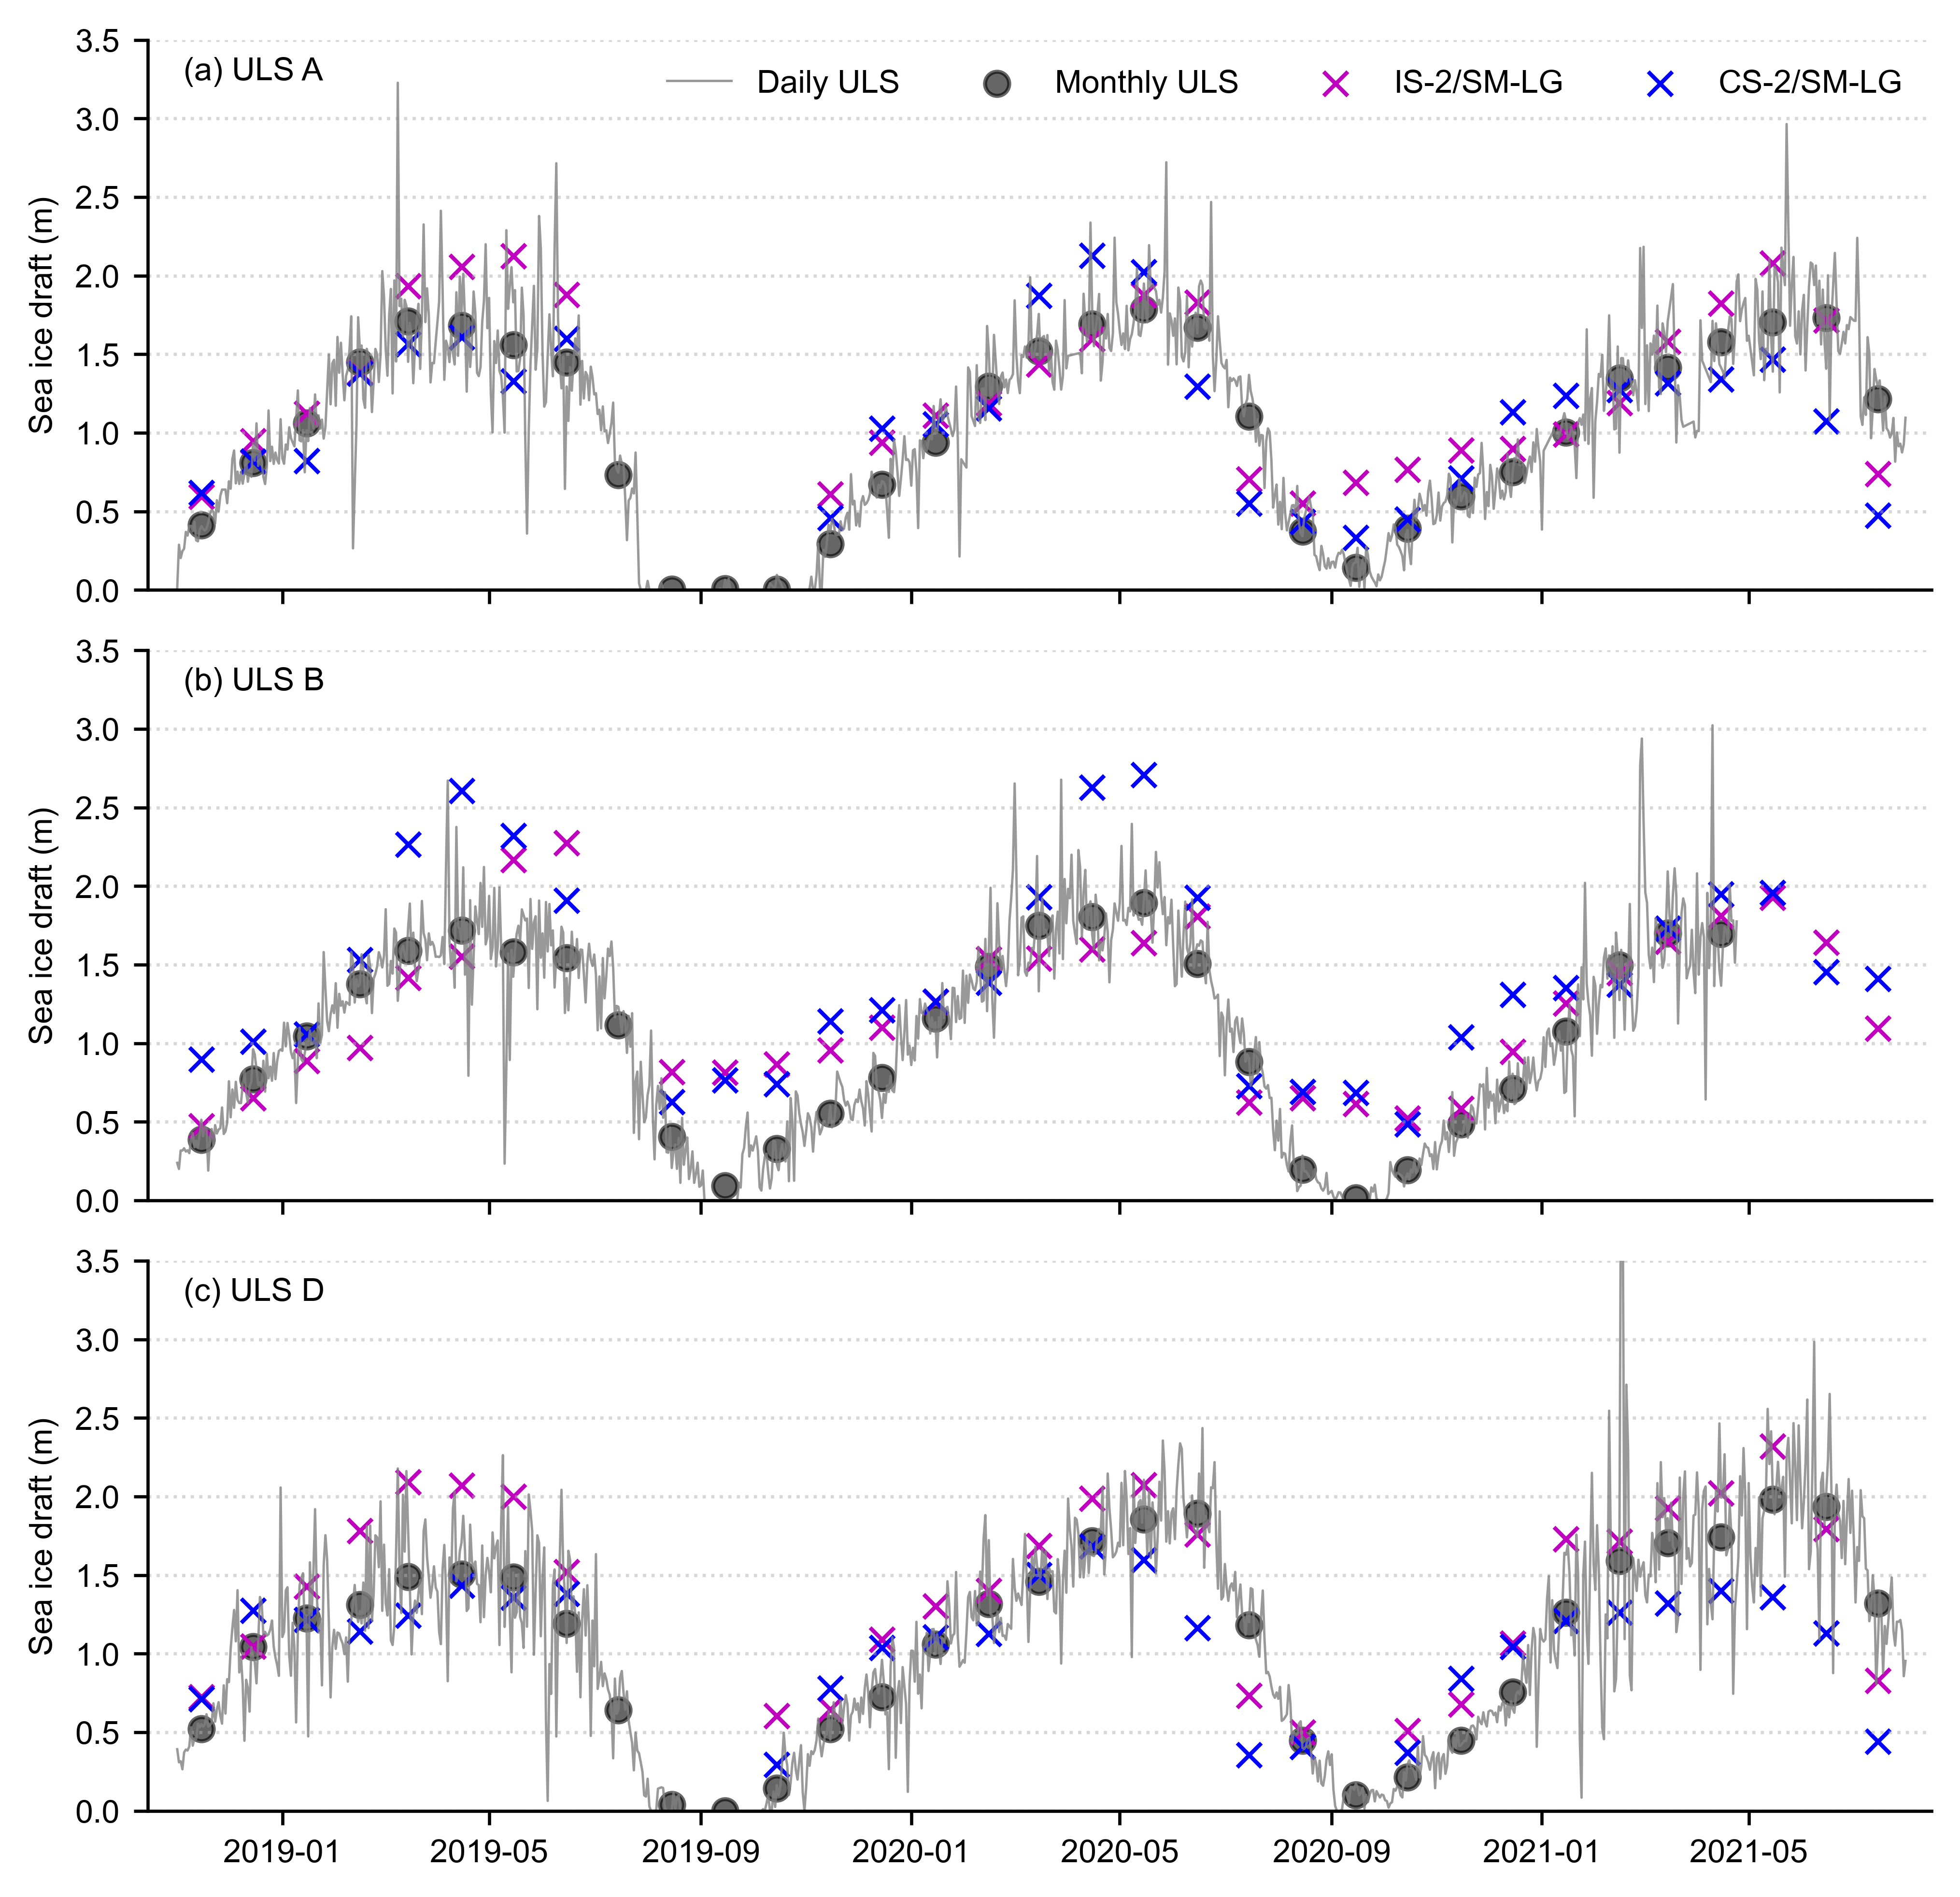

In [19]:
# Define a function to create plots for a given option
option_labels = ['IS-2/SM-LG', 'CS-2/SM-LG']
fig, axes = plt.subplots(3, 1, figsize=(6.8, 6.5), sharex=True)

# Plot for ULS A
axes[0].plot(uls_mean_daily_draft_a.index, uls_mean_daily_draft_a, label="Daily ULS", color='gray', linewidth=0.6, alpha=0.8)
axes[0].scatter(uls_mean_monthly_draft_a.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_a, label="Monthly ULS", marker='o', alpha=0.6, color='k')
axes[0].scatter(IS2_date_range, monthly_IS2_at_ULS_a_options[option_labels[0]], label=option_labels[0], color='m', marker='x')
axes[0].scatter(IS2_date_range, monthly_IS2_at_ULS_a_options[option_labels[1]], label=option_labels[1], color='b', marker='x')
#axes[0].scatter(IS2_date_range, uls_mean_monthly_draft_a_IS2_period, label=option, color='m', marker='x')

axes[0].annotate('(a) ULS A', xy=(0.02, 0.97), xycoords='axes fraction', verticalalignment='top')
axes[0].legend(loc='upper right', frameon=False, ncols=4)

# Plot for ULS B
axes[1].plot(uls_mean_daily_draft_b.index, uls_mean_daily_draft_b, label="Daily ULS", color='gray', linewidth=0.6, alpha=0.8)
axes[1].scatter(uls_mean_monthly_draft_b.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_b, label="Monthly ULS", marker='o', alpha=0.6, color='k')
axes[1].scatter(IS2_date_range, monthly_IS2_at_ULS_b_options[option_labels[0]], label=option_labels[0], color='m', marker='x')
axes[1].scatter(IS2_date_range, monthly_IS2_at_ULS_b_options[option_labels[1]], label=option_labels[1], color='b', marker='x')

#axes[1].scatter(uls_mean_monthly_draft_b.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_b, label=option, color='b', marker='x')
axes[1].annotate('(b) ULS B', xy=(0.02, 0.97), xycoords='axes fraction', verticalalignment='top')


# Plot for ULS D
axes[2].plot(uls_mean_daily_draft_d.index, uls_mean_daily_draft_d, label="Daily ULS", color='gray', linewidth=0.6, alpha=0.8)
axes[2].scatter(uls_mean_monthly_draft_d.index.to_timestamp() + pd.Timedelta(days=14), uls_mean_monthly_draft_d, label="Monthly ULS", marker='o', alpha=0.6, color='k')
#axes[2].scatter(IS2_date_range, uls_mean_monthly_draft_d_IS2_period , label=option, color='m', marker='x')
axes[2].scatter(IS2_date_range, monthly_IS2_at_ULS_d_options[option_labels[0]], label=option_labels[0], color='m', marker='x')
axes[2].scatter(IS2_date_range, monthly_IS2_at_ULS_d_options[option_labels[1]], label=option_labels[1], color='b', marker='x')

axes[2].annotate('(c) ULS D', xy=(0.02, 0.97), xycoords='axes fraction', verticalalignment='top')
axes[2].set_ylabel('Sea ice draft (m)')


for ax in axes:
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Add horizontal gridlines
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    ax.set_ylim([0, 3.5])
    ax.set_ylabel('Sea ice draft (m)')
    ax.set_xlim([pd.Timestamp('2018-10-15'), pd.Timestamp('2021-08-15')])


plt.subplots_adjust(left=0.065, right=0.97, top=0.98, bottom=0.04, hspace=0.11)  # Adjust these values to reduce whitespace
plt.savefig('./figs/BGEP_allseason_res'+str(comp_res)+'_nn_'+start_date+end_date+int_str+'_inccs2.pdf', dpi=300)
plt.show()


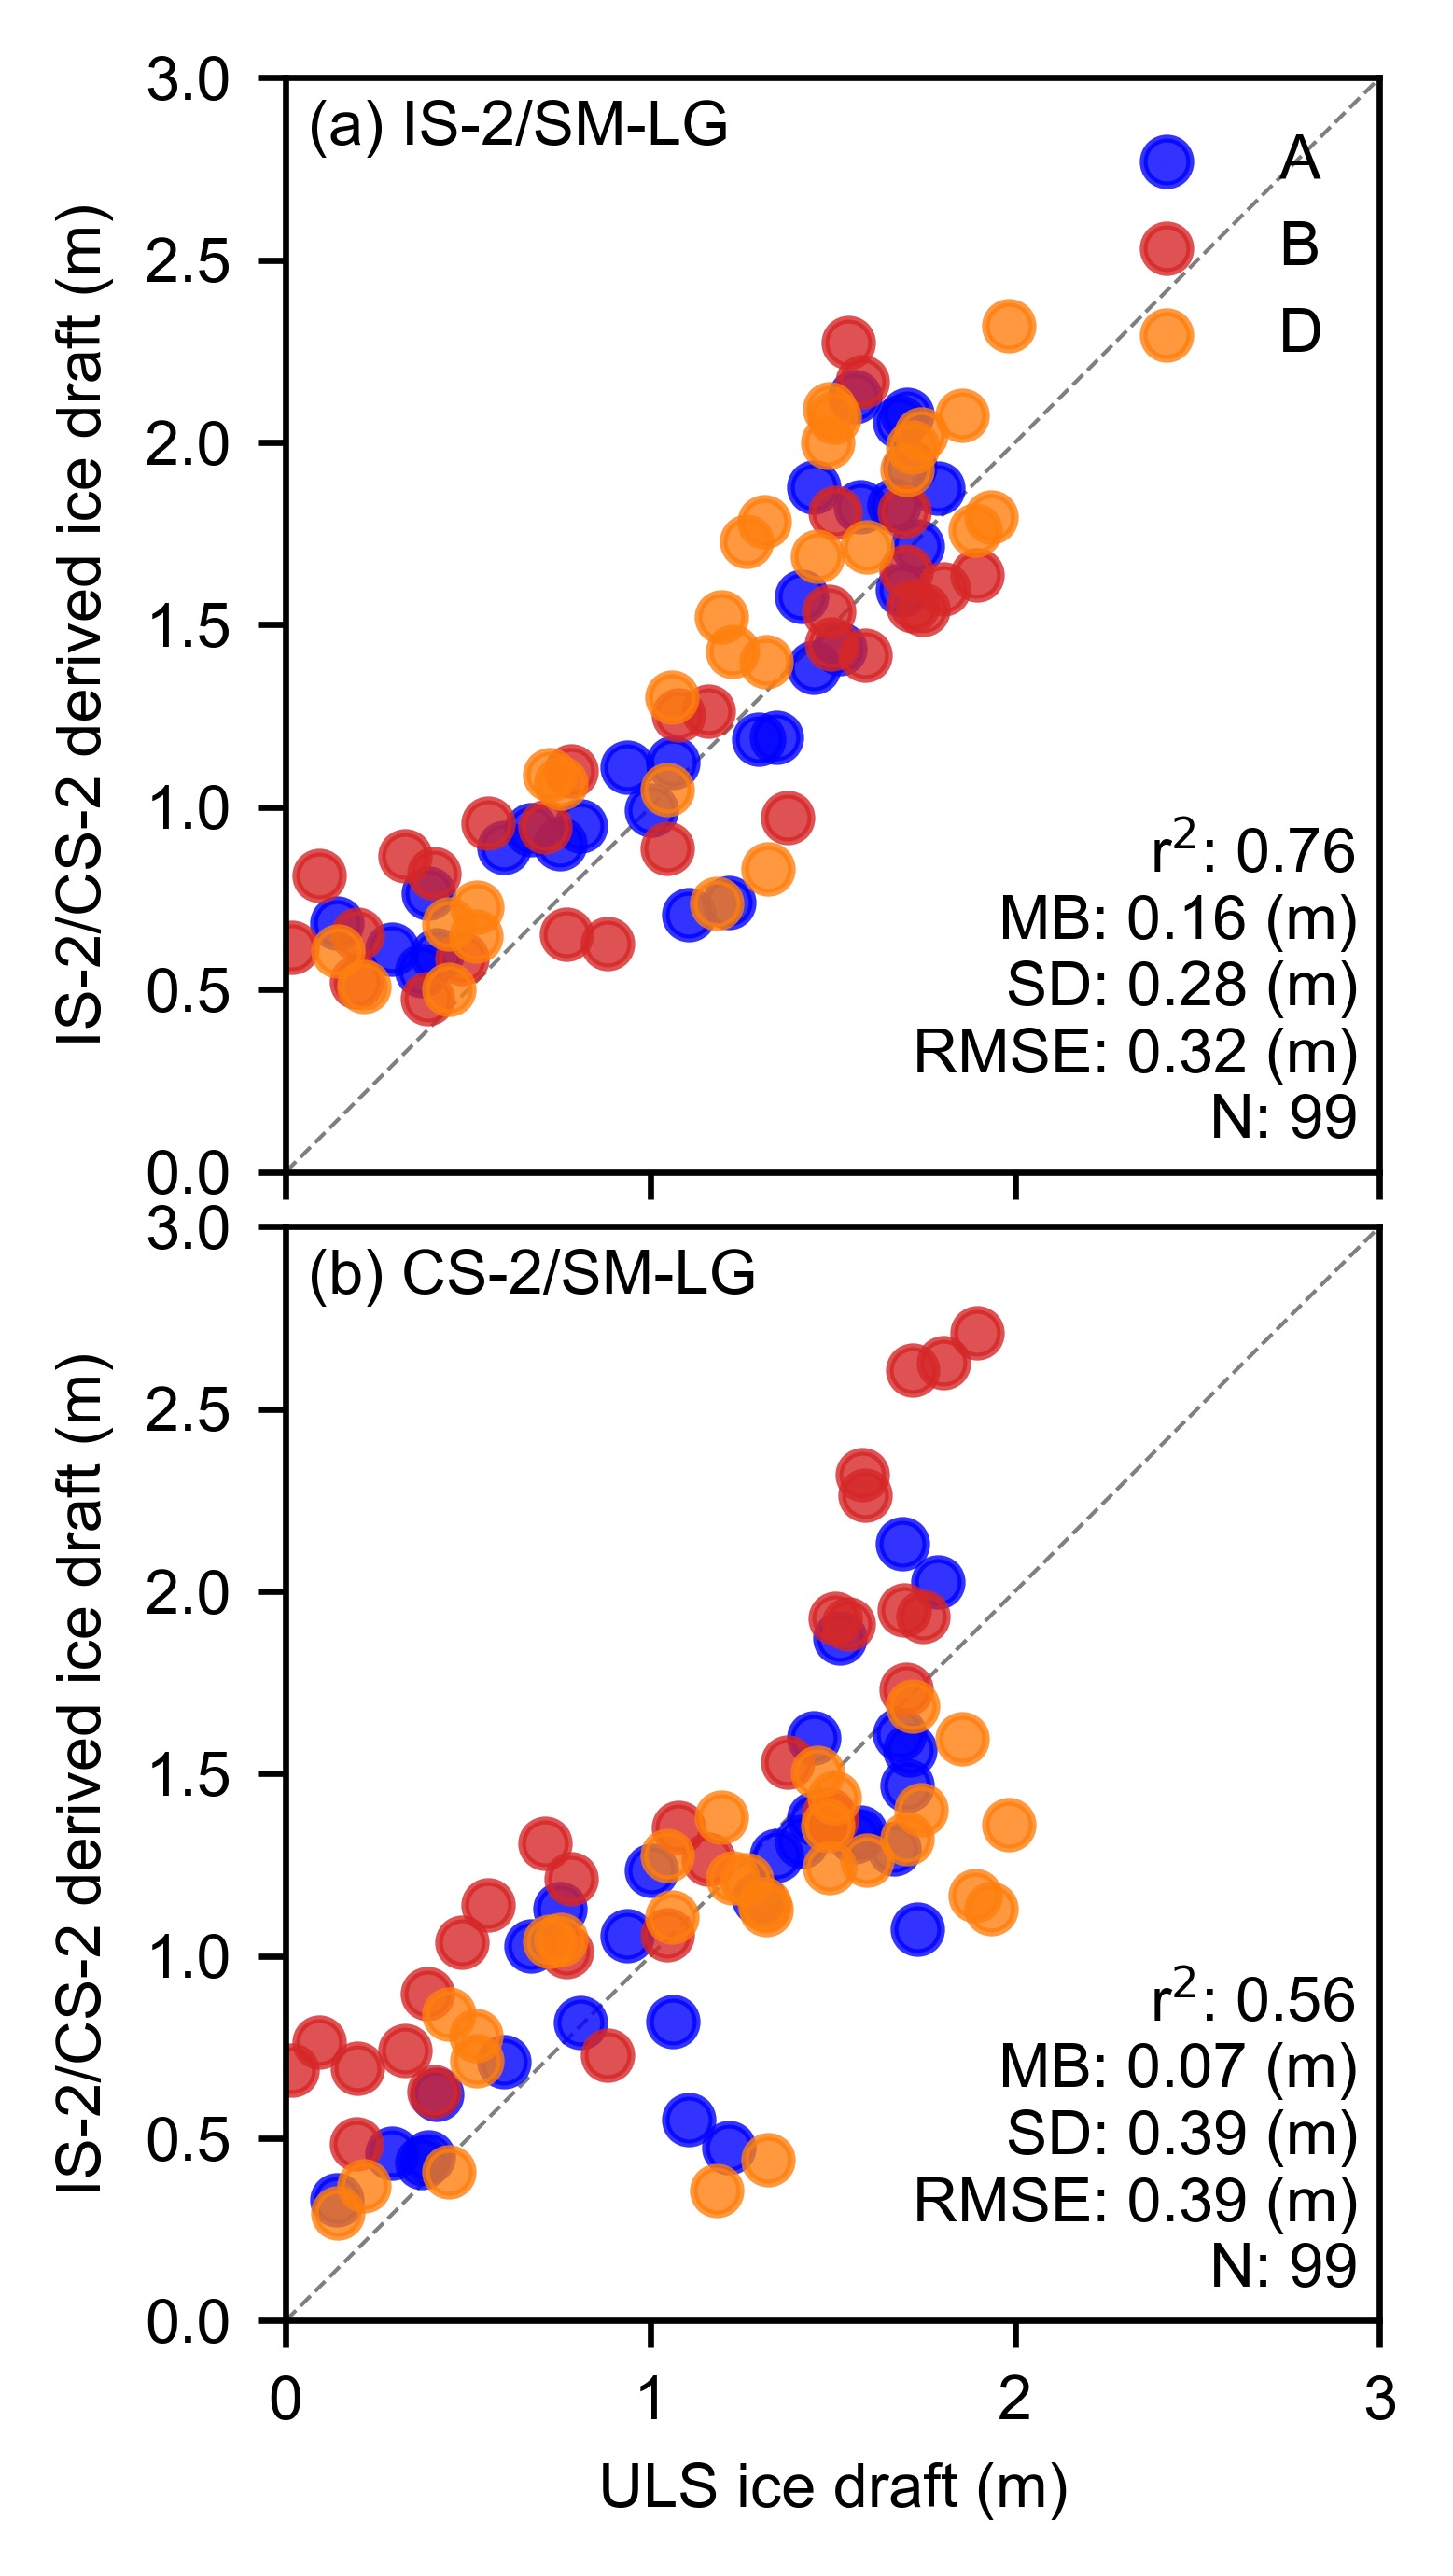

In [20]:

# Create a single column with two rows for the two options
fig, axes = plt.subplots(2, 1, figsize=(2.8, 4.5), gridspec_kw={'hspace': 0.05})  # Adjust hspace for less whitespace
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
panel_labels = ['(a)', '(b)']  # Panel labels

# Iterate over the first two options
for i, option in enumerate(list(options.keys())[:2]):
    ax = axes[i]
    ax.scatter(uls_mean_monthly_draft_a_IS2_period, monthly_IS2_at_ULS_a_options[option], color='b', alpha=0.8, label='A')
    ax.scatter(uls_mean_monthly_draft_b_IS2_period, monthly_IS2_at_ULS_b_options[option], color='tab:red', alpha=0.8, label='B')
    ax.scatter(uls_mean_monthly_draft_d_IS2_period, monthly_IS2_at_ULS_d_options[option], color='tab:orange', alpha=0.8, label='D')

    # Retrieve validation results for the current option
    r_str_all = validation_results[option]['r_str_all']
    mb_str_all = validation_results[option]['mb_str_all']
    sd_str_all = validation_results[option]['sd_str_all']
    rmse_all = np.sqrt(np.nanmean((np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period))**2))
    n_str = str(len(monthly_IS2_at_ULS_all_options[option]))
    # Annotate the plot with RMSE, mean bias, and standard deviation
    ax.annotate(f"r$^2$: {r_str_all} \nMB: {mb_str_all} (m)\nSD: {sd_str_all} (m)\nRMSE: {rmse_all:.02f} (m)\nN: {n_str}", color='k', xy=(0.98, 0.02), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

    # Combine panel label with option label
    ax.annotate(f"{panel_labels[i]} "+option, xy=(0.02, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

    # Set x and y labels only for the leftmost and bottom plots
    if i == 0:
        ax.legend(frameon=False, loc="upper right")
        ax.set_xticklabels('')
        ax.set_xlabel('')
    else:
        ax.set_xlabel('ULS ice draft (m)')
    ax.set_ylabel('IS-2/CS-2 derived ice draft (m)')
    

    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', linewidth=0.5, alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.subplots_adjust(left=0.065, right=0.99, top=0.98, bottom=0.09)  # Adjust these values to reduce whitespace

plt.savefig('./figs/BGEP_allseason_scatter_res'+str(comp_res)+'_nn_'+start_date+end_date+int_str+'_inccs2.pdf', dpi=300)
plt.show()

# OK now just do summer month (May to August) comparisons!

In [21]:
# Filter for summer months (May=5 through August=8)
IS2_date_range = IS2_date_range[IS2_date_range.month.isin([5, 6, 7, 8])]

# Create date strings for filtered range
IS2_date_range_strs = [str(date.year)+'-%02d'%(date.month) for date in IS2_date_range]

print("Summer dates:", IS2_date_range_strs)

Summer dates: ['2019-05', '2019-06', '2019-07', '2019-08', '2020-05', '2020-06', '2020-07', '2020-08', '2021-05', '2021-06', '2021-07']


In [22]:
# Repeat functions from above (should really streamline this more)
# Compute monthly ULS values for each option
monthly_IS2_at_ULS_a_options = {}
monthly_IS2_at_ULS_b_options = {}
monthly_IS2_at_ULS_d_options = {}
monthly_IS2_at_ULS_all_options = {}

for option in options.keys():
    monthly_IS2_at_ULS_a_options[option] = [
        grid_IS2_nearby(date, option, uls_x_a, uls_y_a, res=comp_res) for date in IS2_date_range
    ]
    monthly_IS2_at_ULS_b_options[option] = [
        grid_IS2_nearby(date, option,uls_x_b, uls_y_b, res=comp_res) for date in IS2_date_range
    ]
    monthly_IS2_at_ULS_d_options[option] = [
        grid_IS2_nearby(date, option,uls_x_d, uls_y_d, res=comp_res) for date in IS2_date_range
    ]
    # Combine all ULS values for the current option
    monthly_IS2_at_ULS_all_options[option] = (
        monthly_IS2_at_ULS_a_options[option] +
        monthly_IS2_at_ULS_b_options[option] +
        monthly_IS2_at_ULS_d_options[option]
    )


2019-05-15 00:00:00 IS-2/SM-LG 2.1249423
2019-06-15 00:00:00 IS-2/SM-LG 1.8776155
2019-07-15 00:00:00 IS-2/SM-LG nan
2019-08-15 00:00:00 IS-2/SM-LG nan
2020-05-15 00:00:00 IS-2/SM-LG 1.8750578
2020-06-15 00:00:00 IS-2/SM-LG 1.8289809
2020-07-15 00:00:00 IS-2/SM-LG 0.70578855
2020-08-15 00:00:00 IS-2/SM-LG 0.55099994
2021-05-15 00:00:00 IS-2/SM-LG 2.0777307
2021-06-15 00:00:00 IS-2/SM-LG 1.71525
2021-07-15 00:00:00 IS-2/SM-LG 0.7386345
2019-05-15 00:00:00 IS-2/SM-LG 2.16676
2019-06-15 00:00:00 IS-2/SM-LG 2.27472
2019-07-15 00:00:00 IS-2/SM-LG nan
2019-08-15 00:00:00 IS-2/SM-LG 0.81884444
2020-05-15 00:00:00 IS-2/SM-LG 1.6374398
2020-06-15 00:00:00 IS-2/SM-LG 1.8070999
2020-07-15 00:00:00 IS-2/SM-LG 0.62468004
2020-08-15 00:00:00 IS-2/SM-LG 0.651
2021-05-15 00:00:00 IS-2/SM-LG 1.9285
2021-06-15 00:00:00 IS-2/SM-LG 1.64134
2021-07-15 00:00:00 IS-2/SM-LG 1.0927
2019-05-15 00:00:00 IS-2/SM-LG 1.99896
2019-06-15 00:00:00 IS-2/SM-LG 1.5218371
2019-07-15 00:00:00 IS-2/SM-LG nan
2019-08-15 00:0

In [23]:
uls_dates=uls_mean_monthly_draft_a.index.astype(str)
uls_mean_monthly_draft_a_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_a, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_b.index.astype(str)
uls_mean_monthly_draft_b_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_b, uls_dates, date) for date in IS2_date_range_strs]

uls_dates=uls_mean_monthly_draft_d.index.astype(str)
uls_mean_monthly_draft_d_IS2_period  = [get_ULS_dates(uls_mean_monthly_draft_d, uls_dates, date) for date in IS2_date_range_strs]
                                        
uls_mean_monthly_draft_IS2_period = uls_mean_monthly_draft_a_IS2_period+uls_mean_monthly_draft_b_IS2_period+uls_mean_monthly_draft_d_IS2_period


In [24]:
# Validation analysis for each option
validation_results = {}

for option in options.keys():
    print(option)
    # ULS A
    mask_a = ~np.isnan(monthly_IS2_at_ULS_a_options[option])& ~np.isnan(uls_mean_monthly_draft_a_IS2_period)
    res_a = stats.linregress(
        np.array(monthly_IS2_at_ULS_a_options[option])[mask_a],
        np.array(uls_mean_monthly_draft_a_IS2_period)[mask_a]
    )
    r_str_a = '%.02f' % (res_a[2]**2)
    mb_str_a = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_a_options[option]) - np.array(uls_mean_monthly_draft_a_IS2_period)))
    sd_str_a = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_a_options[option]) - np.array(uls_mean_monthly_draft_a_IS2_period)))

    # ULS B
    mask_b = ~np.isnan(monthly_IS2_at_ULS_b_options[option])& ~np.isnan(uls_mean_monthly_draft_b_IS2_period)
    res_b = stats.linregress(
        np.array(monthly_IS2_at_ULS_b_options[option])[mask_b],
        np.array(uls_mean_monthly_draft_b_IS2_period)[mask_b]
    )
    r_str_b = '%.02f' % (res_b[2]**2)
    mb_str_b = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_b_options[option]) - np.array(uls_mean_monthly_draft_b_IS2_period)))
    sd_str_b = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_b_options[option]) - np.array(uls_mean_monthly_draft_b_IS2_period)))

    # ULS D
    mask_d = ~np.isnan(monthly_IS2_at_ULS_d_options[option])& ~np.isnan(uls_mean_monthly_draft_b_IS2_period)
    res_d = stats.linregress(
        np.array(monthly_IS2_at_ULS_d_options[option])[mask_d],
        np.array(uls_mean_monthly_draft_d_IS2_period)[mask_d]
    )
    r_str_d = '%.02f' % (res_d[2]**2)
    mb_str_d = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_d_options[option]) - np.array(uls_mean_monthly_draft_d_IS2_period)))
    sd_str_d = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_d_options[option]) - np.array(uls_mean_monthly_draft_d_IS2_period)))

    # ULS ALL
    mask_all = ~np.isnan(monthly_IS2_at_ULS_all_options[option])& ~np.isnan(uls_mean_monthly_draft_IS2_period)
    res_all = stats.linregress(
        np.array(monthly_IS2_at_ULS_all_options[option])[mask_all],
        np.array(uls_mean_monthly_draft_IS2_period)[mask_all]
    )
    r_str_all = '%.02f' % (res_all[2]**2)
    mb_str_all = '%.02f' % (np.nanmean(np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period)))
    sd_str_all = '%.02f' % (np.nanstd(np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period)))

    # Store results
    validation_results[option] = {
        'r_str_a': r_str_a, 'mb_str_a': mb_str_a, 'sd_str_a': sd_str_a,
        'r_str_b': r_str_b, 'mb_str_b': mb_str_b, 'sd_str_b': sd_str_b,
        'r_str_d': r_str_d, 'mb_str_d': mb_str_d, 'sd_str_d': sd_str_d,
        'r_str_all': r_str_all, 'mb_str_all': mb_str_all, 'sd_str_all': sd_str_all
    }

validation_results

IS-2/SM-LG
CS-2/SM-LG


{'IS-2/SM-LG': {'r_str_a': '0.71',
  'mb_str_a': '0.10',
  'sd_str_a': '0.33',
  'r_str_b': '0.70',
  'mb_str_b': '0.28',
  'sd_str_b': '0.36',
  'r_str_d': '0.73',
  'mb_str_d': '0.03',
  'sd_str_d': '0.33',
  'r_str_all': '0.67',
  'mb_str_all': '0.12',
  'sd_str_all': '0.36'},
 'CS-2/SM-LG': {'r_str_a': '0.59',
  'mb_str_a': '-0.26',
  'sd_str_a': '0.33',
  'r_str_b': '0.89',
  'mb_str_b': '0.41',
  'sd_str_b': '0.30',
  'r_str_d': '0.52',
  'mb_str_d': '-0.46',
  'sd_str_d': '0.38',
  'r_str_all': '0.42',
  'mb_str_all': '-0.14',
  'sd_str_all': '0.49'}}

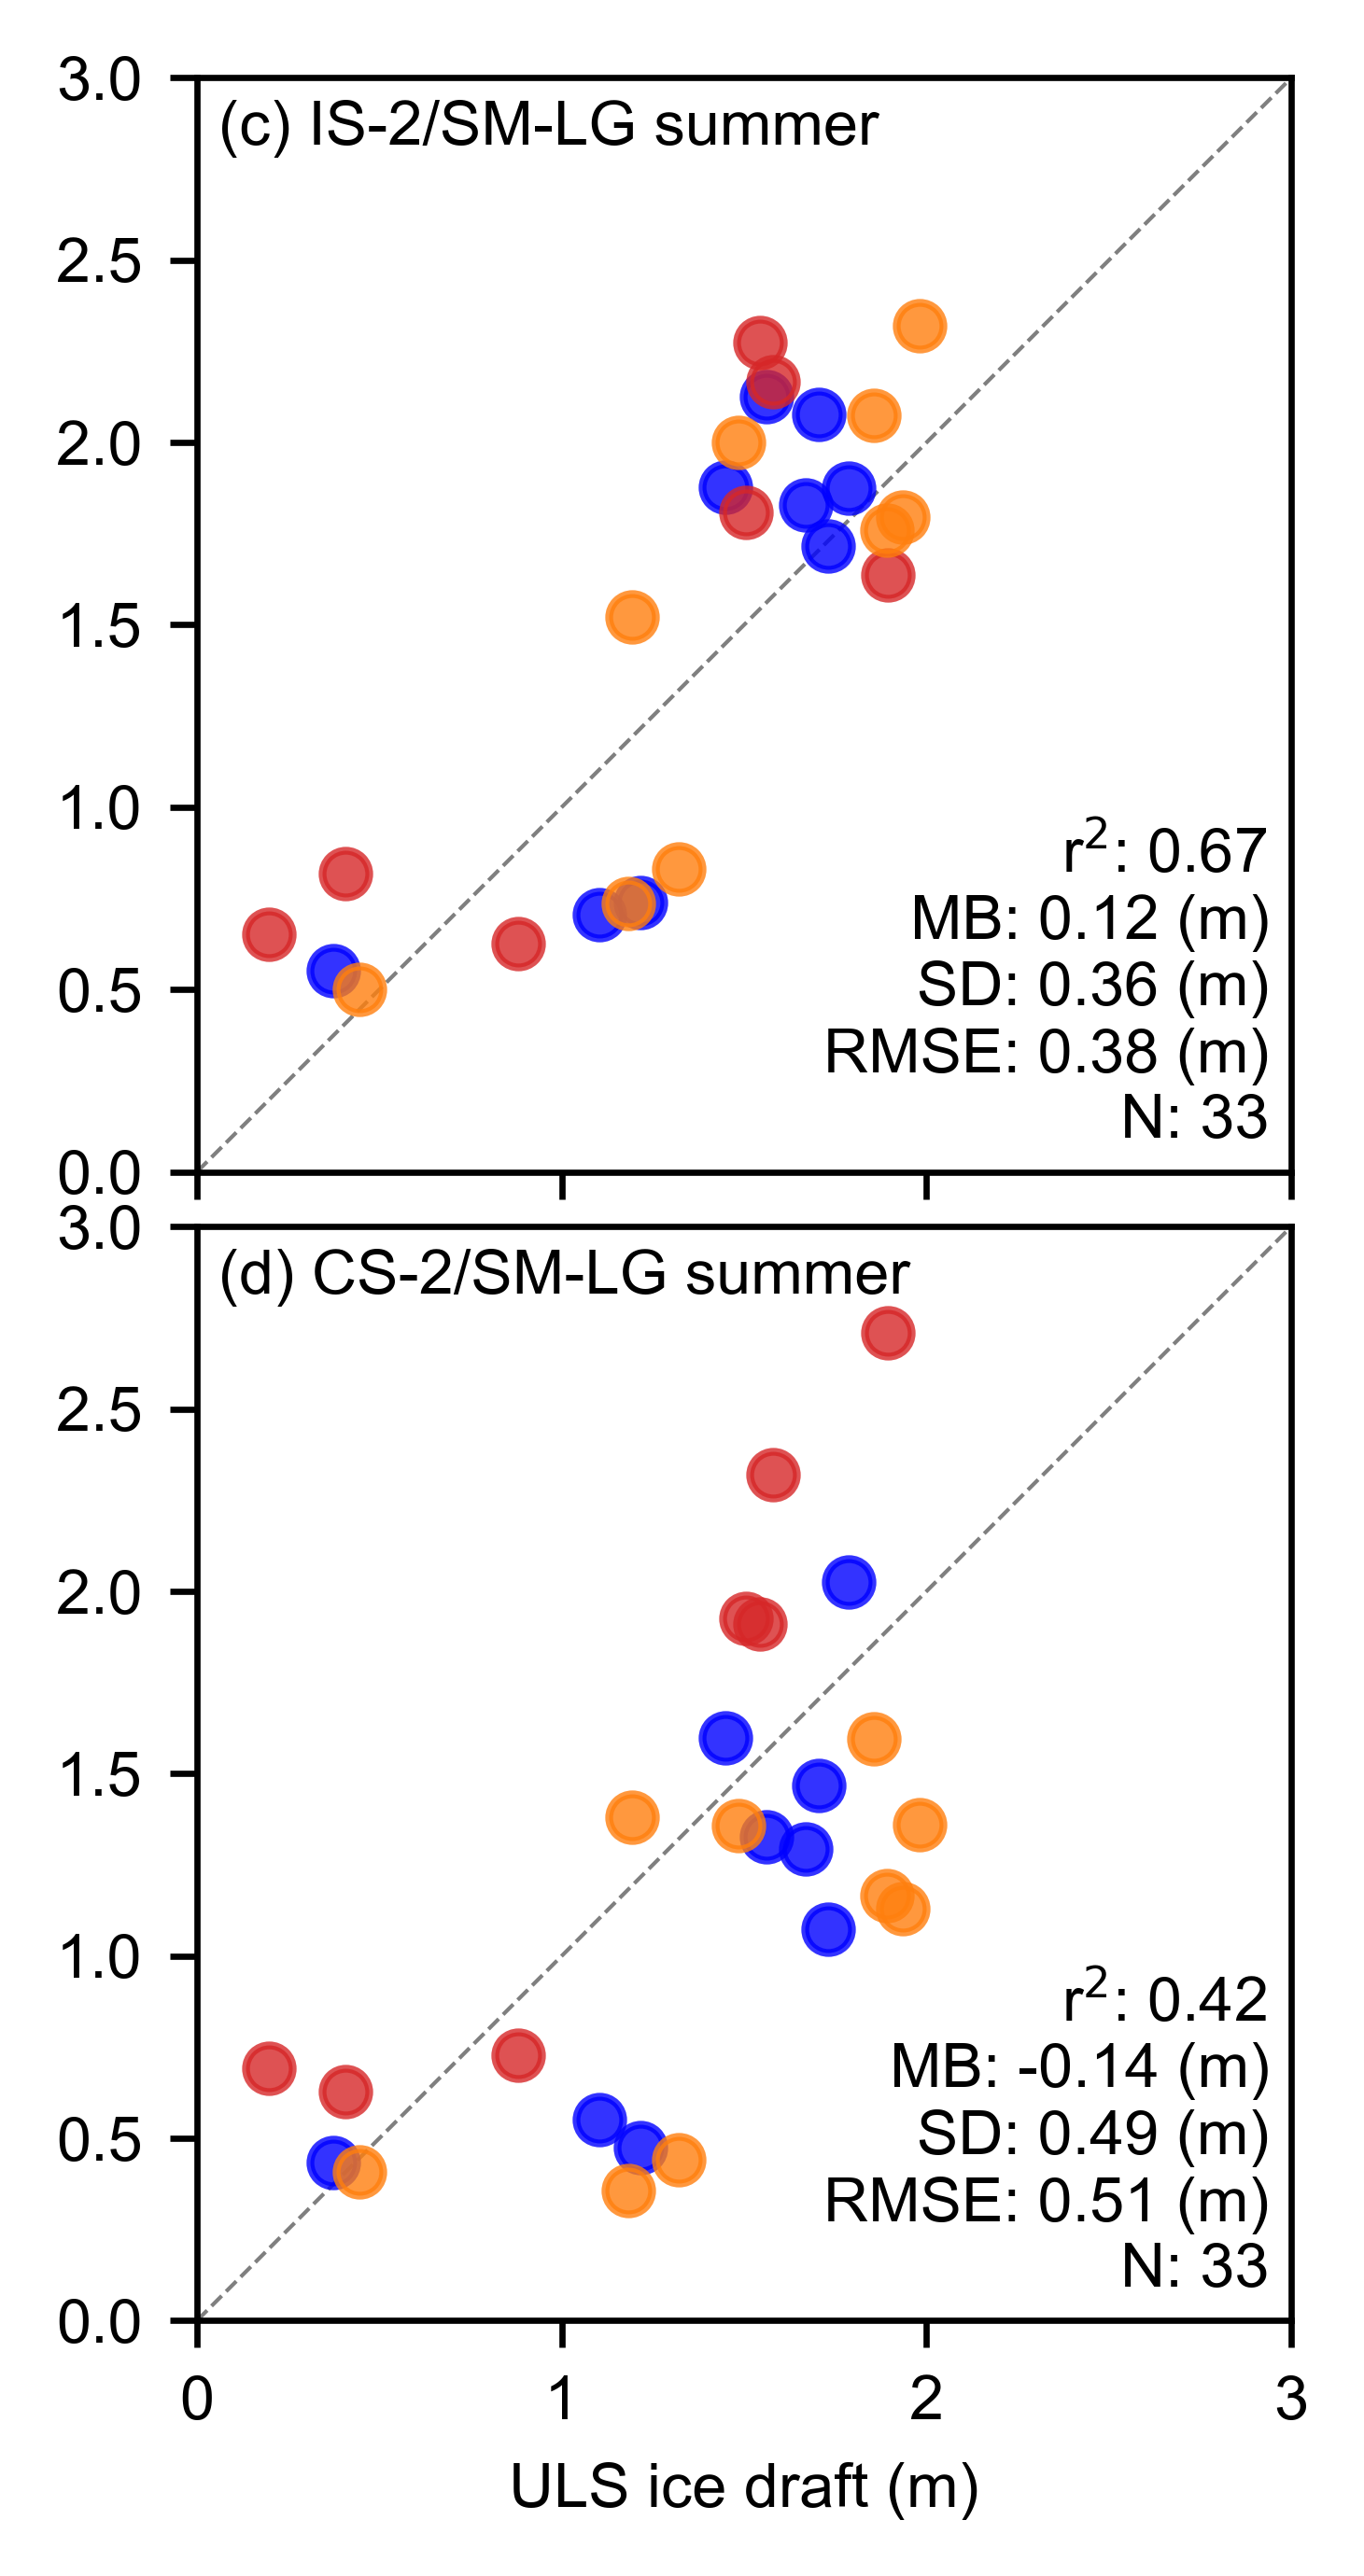

In [25]:

# Create a single column with two rows for the two options
fig, axes = plt.subplots(2, 1, figsize=(2.8, 4.5), gridspec_kw={'hspace': 0.05})  # Adjust hspace for less whitespace
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
panel_labels = ['(c)', '(d)']  # Panel labels

# Iterate over the first two options
for i, option in enumerate(list(options.keys())[:2]):
    ax = axes[i]
    ax.scatter(uls_mean_monthly_draft_a_IS2_period, monthly_IS2_at_ULS_a_options[option], color='b', alpha=0.8, label='A')
    ax.scatter(uls_mean_monthly_draft_b_IS2_period, monthly_IS2_at_ULS_b_options[option], color='tab:red', alpha=0.8, label='B')
    ax.scatter(uls_mean_monthly_draft_d_IS2_period, monthly_IS2_at_ULS_d_options[option], color='tab:orange', alpha=0.8, label='D')

    # Retrieve validation results for the current option
    r_str_all = validation_results[option]['r_str_all']
    mb_str_all = validation_results[option]['mb_str_all']
    sd_str_all = validation_results[option]['sd_str_all']
    rmse_all = np.sqrt(np.nanmean((np.array(monthly_IS2_at_ULS_all_options[option]) - np.array(uls_mean_monthly_draft_IS2_period))**2))
    n_str = str(len(monthly_IS2_at_ULS_all_options[option]))
    # Annotate the plot with RMSE, mean bias, and standard deviation
    ax.annotate(f"r$^2$: {r_str_all} \nMB: {mb_str_all} (m)\nSD: {sd_str_all} (m)\nRMSE: {rmse_all:.02f} (m)\nN: {n_str}", color='k', xy=(0.98, 0.02), xycoords='axes fraction', horizontalalignment='right', verticalalignment='bottom')

    # Combine panel label with option label
    ax.annotate(f"{panel_labels[i]} "+option+' summer', xy=(0.02, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

    # Set x and y labels only for the leftmost and bottom plots
    if i == 0:
        #ax.legend(frameon=False, loc="upper right")
        ax.set_xticklabels('')
        ax.set_xlabel('')
    else:
        ax.set_xlabel('ULS ice draft (m)')
    #ax.set_ylabel('IS-2/CS-2 derived ice draft (m)')
    

    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', linewidth=0.5, alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.subplots_adjust(left=0.065, right=0.99, top=0.98, bottom=0.09)
plt.savefig('./figs/BGEP_summer_scatter_res'+str(comp_res)+'_nn_'+start_date+end_date+int_str+'_inccs2.pdf', dpi=300)
plt.show()